## **In this notebook, we use following autoencoder for compression.**

><ul>
><li>Preprocessing: Custom Normalization $E$ -> $(\log_{10} E) / 3$, $p_T$ -> $(\log_{10} p_T) / 3$, $\eta$ -> $\eta / 3$, $\phi$ -> $\phi / 3$</li>
><li>Architecture: in-200-200-20-3-20-200-200-out</li>
><li>Elu Activation</li>
><li>BatchNorm</li>
><li>Epoch: 200</li>
></ul>

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

In [28]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

>### **Data Preparation**

In [3]:
unnormed_train_path = './jet_data_unnormed_80train.pkl'
unnormed_test_path = './jet_data_unnormed_20test.pkl'

unnormed_train = pd.read_pickle(unnormed_train_path)
unnormed_test = pd.read_pickle(unnormed_test_path)

In [4]:
def get_custom_normalize_data():
    
    train = pd.read_pickle(unnormed_train_path)
    test = pd.read_pickle(unnormed_test_path)
    train['pt'] = train['pt'].apply(lambda x: np.log10(x) / 3.)
    train['E'] = train['E'].apply(lambda x: np.log10(x)  / 3.)
    train['eta'] = train['eta'] / 3.
    train['phi'] = train['phi'] / 3.
    
    test['pt'] = test['pt'].apply(lambda x: np.log10(x) / 3.)
    test['E'] = test['E'].apply(lambda x: np.log10(x) / 3.)
    test['eta'] = test['eta'] / 3.
    test['phi'] = test['phi'] / 3.

    return train.astype('float32'), test.astype('float32')

In [5]:
train, test = get_custom_normalize_data()

In [6]:
unnormed_train.head()

,E,pt,eta,phi
11092,73356.1,68288.8,-0.364836,-2.683820
6607,155625.0,114949.0,0.809188,3.009770
9670,36304.3,27072.0,0.792701,0.196966
13354,329132.0,280958.0,-0.575831,2.154610
16500,855691.0,647140.0,0.781380,-3.058920


In [7]:
train.head()

,E,pt,eta,phi
11092,1.621812,1.611450,-0.121612,-0.894607
6607,1.730693,1.686835,0.269729,1.003257
9670,1.519986,1.477507,0.264234,0.065655
13354,1.839123,1.816214,-0.191944,0.718203
16500,1.977439,1.936999,0.260460,-1.019640


In [8]:
train_x = train
test_x = test
train_y = train_x
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [9]:
bs = 256

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

>### **Model Preparation**

In [10]:
class AE_3D_200_Elu_BatchNorm(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_Elu_BatchNorm, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.en2 = nn.Linear(200, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.en3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.en4 = nn.Linear(20, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 20)
        self.bn6 = nn.BatchNorm1d(20)
        self.de2 = nn.Linear(20, 200)
        self.bn7 = nn.BatchNorm1d(200)
        self.de3 = nn.Linear(200, 200)
        self.bn8 = nn.BatchNorm1d(200)
        self.de4 = nn.Linear(200, n_features)
        self.elu = nn.ELU()

    def encode(self, x):
        h1 = self.bn1(self.elu(self.en1(x)))
        h2 = self.bn2(self.elu(self.en2(h1)))
        h3 = self.bn3(self.elu(self.en3(h2)))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.bn6(self.elu(self.de1(self.bn5(self.elu(x)))))
        h6 = self.bn7(self.elu(self.de2(h5)))
        h7 = self.bn8(self.elu(self.de3(h6)))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_Elu_BatchNorm()

In [11]:
loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.0033113110810518267
Learning rate with the steepest gradient: 0.02290867641568184


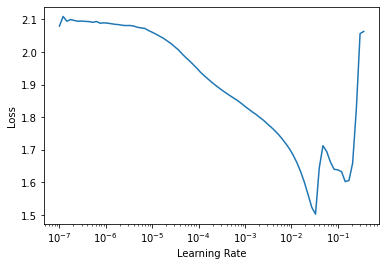

In [12]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

>### **Begin Training**

In [13]:
start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=200, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 1.516800880432129, 1.4600591659545898, '00:01']
[0, 1.516800880432129, 1.4600591659545898, '00:01']
[1, 1.4047646522521973, 1.3269574642181396, '00:01']
[1, 1.4047646522521973, 1.3269574642181396, '00:01']
[2, 1.2380907535552979, 1.0970126390457153, '00:01']
[2, 1.2380907535552979, 1.0970126390457153, '00:01']
[3, 0.9780099391937256, 0.7619462013244629, '00:01']
[3, 0.9780099391937256, 0.7619462013244629, '00:01']
[4, 0.6400877237319946, 0.39109745621681213, '00:01']
[4, 0.6400877237319946, 0.39109745621681213, '00:01']
[5, 0.30665621161460876, 0.10373123735189438, '00:01']
[5, 0.30665621161460876, 0.10373123735189438, '00:01']
[6, 0.09629563987255096, 0.007526866625994444, '00:01']
[6, 0.09629563987255096, 0.007526866625994444, '00:01']
[7, 0.025875015184283257, 0.0022664295975118876, '00:01']
[7, 0.025875015184283257, 0.0022664295975118876, '00:01']
[8, 0.008666792884469032, 0.0023115272633731365, '00:01']
[8, 0.008666792884469032, 0.0023115272633731365, '00:01']
[9, 0.0046227318

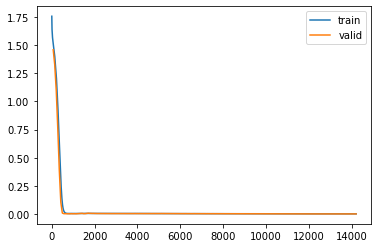

In [14]:
recorder.plot_loss()

In [15]:
learn.validate()

(#1) [0.00024162165937013924]

>### **Saving Model**

In [16]:
save_path = './Models/AE_3D_200_Elu_BatchNorm_200Epoch.pt'
torch.save(model.state_dict(), save_path)

>### **Visualize and Analyze the model predictions**

In [17]:
def calc_rms(arr):
    arr = arr.flatten()
    arr[arr == np.nan] = 1
    return np.sqrt(np.sum(arr**2) / len(arr))

In [18]:
def unnormalize_predictions(prediction):
    
    unnormed_pred = prediction.clone() 
    unnormed_pred[:, 0] = 10 ** (3 * pred[:, 0])
    unnormed_pred[:, 1] = 10 ** (3 * pred[:, 1])
    unnormed_pred[:, 2] = 3 * pred[:, 2]
    unnormed_pred[:, 3] = 3 * pred[:, 3]
    
    return unnormed_pred

In [29]:
def plot_input_vs_output(unnormed_test_data, unnormed_test_pred, save=False):

    n_bins = 100
    colors = ['orange', 'c']
    alph = 0.8


    for kk in np.arange(4):
        plt.subplot(2, 2, kk+1)
        n_hist_data, bin_edges, _ = plt.hist(unnormed_test_data[:, kk].detach().numpy(), color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(unnormed_test_pred[:, kk].detach().numpy(), color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.xlabel(test.columns[kk])
        plt.ylabel('Number of events')
        plt.legend()
        
        if save:
            plt.savefig("./Plots/AE_3D_200_Elu_BatchNorm_200Epoch/input_vs_output_fourmomentum",dpi=300)

In [33]:
def plot_residuals(unnormed_test_data, unnormed_test_pred, save=False):
    residual_strings = [r'$(E_{recon} - E_{true}) / E_{true}$',
                        r'$(p_{T,recon} - p_{T,true}) / p_{T,true}$',
                    r'$(\eta_{recon} - \eta_{true}) / \eta_{true}$',
                    r'$(\phi_{recon} - \phi_{true}) / \phi_{true}$']
    line_style = ['--', '-']
    alph = 0.8
    
    residuals = (unnormed_test_pred.detach().numpy() - unnormed_test_data.detach().numpy()) / unnormed_test_data.detach().numpy()
    range_res = (-.02, .02)
    

    for kk in np.arange(4):
        plt.subplot(2, 2, kk+1)
        n_hist_pred, bin_edges, _ = plt.hist(residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=200, range=range_res)
        plt.title('Residuals of %s' % test.columns[kk])
        plt.xlabel(residual_strings[kk])
        plt.ylabel('Number of jets')
        plt.yscale('log')
        rms = calc_rms(residuals[:, kk])
        ax = plt.gca()
        residuals_mean = residuals[:, kk].mean()
        residuals_variance = residuals[:, kk].var()
        plt.text(.2, .5, 'RMS = %f' % (rms), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
                 horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        plt.text(.24, .25, 'Mean = %f\nVariance = %f' % (residuals_mean, residuals_variance), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
                 horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        if save:
            plt.savefig("./Plots/AE_3D_200_Elu_BatchNorm_200Epoch/residuals_fourmomentum",dpi=300)

In [21]:
unnormed_test_data = torch.tensor(unnormed_test.values)
normed_test_data = torch.tensor(test.values)

pred = model(normed_test_data)

unnormed_test_pred = unnormalize_predictions(pred)

In [22]:
print("First 5 Input: ")
print(normed_test_data[0:5])
print('\n')
print("First 5 Output: ")
print(pred[0:5])

First 5 Input: 
tensor([[ 1.9355e+00,  1.9235e+00,  1.3025e-01,  4.1245e-01],
        [ 1.8407e+00,  1.7004e+00,  5.3999e-01, -6.1841e-01],
        [ 1.5587e+00,  1.5570e+00, -5.0219e-04,  8.1866e-01],
        [ 1.5251e+00,  1.4985e+00,  2.0823e-01, -3.0359e-01],
        [ 1.7020e+00,  1.4857e+00, -7.2400e-01,  8.5120e-01]])


First 5 Output: 
tensor([[ 1.9341,  1.9175,  0.1299,  0.3782],
        [ 1.8370,  1.6993,  0.5282, -0.6289],
        [ 1.5522,  1.5528,  0.0060,  0.7931],
        [ 1.5298,  1.4913,  0.2051, -0.3331],
        [ 1.7016,  1.4915, -0.7077,  0.8291]], grad_fn=<SliceBackward>)


In [23]:
print("First 5 Input: ")
print(unnormed_test_data[0:5])
print('\n')
print("First 5 Output: ")
print(unnormed_test_pred[0:5])

First 5 Input: 
tensor([[ 6.4031e+05,  5.8952e+05,  3.9075e-01,  1.2373e+00],
        [ 3.3279e+05,  1.2627e+05,  1.6200e+00, -1.8552e+00],
        [ 4.7444e+04,  4.6892e+04, -1.5066e-03,  2.4560e+00],
        [ 3.7600e+04,  3.1289e+04,  6.2468e-01, -9.1078e-01],
        [ 1.2768e+05,  2.8651e+04, -2.1720e+00,  2.5536e+00]],
       dtype=torch.float64)


First 5 Output: 
tensor([[ 6.3419e+05,  5.6554e+05,  3.8979e-01,  1.1345e+00],
        [ 3.2429e+05,  1.2528e+05,  1.5846e+00, -1.8866e+00],
        [ 4.5340e+04,  4.5532e+04,  1.7859e-02,  2.3794e+00],
        [ 3.8839e+04,  2.9777e+04,  6.1535e-01, -9.9935e-01],
        [ 1.2727e+05,  2.9817e+04, -2.1230e+00,  2.4874e+00]],
       grad_fn=<SliceBackward>)


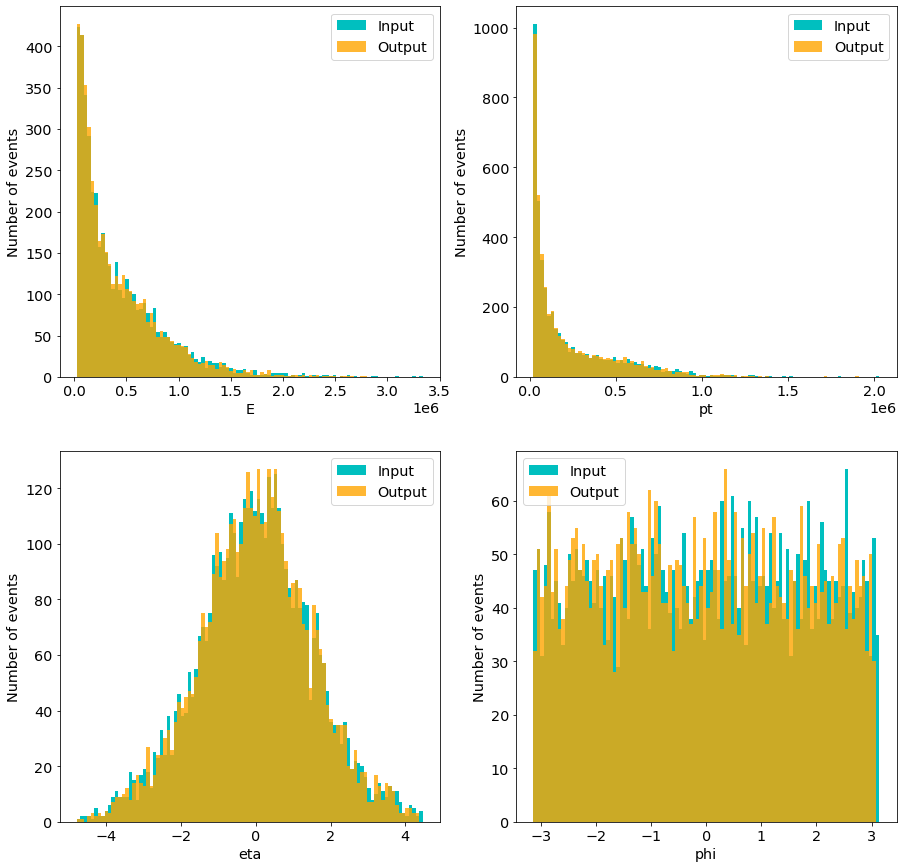

In [31]:
plot_input_vs_output(unnormed_test_data, unnormed_test_pred, save=True)

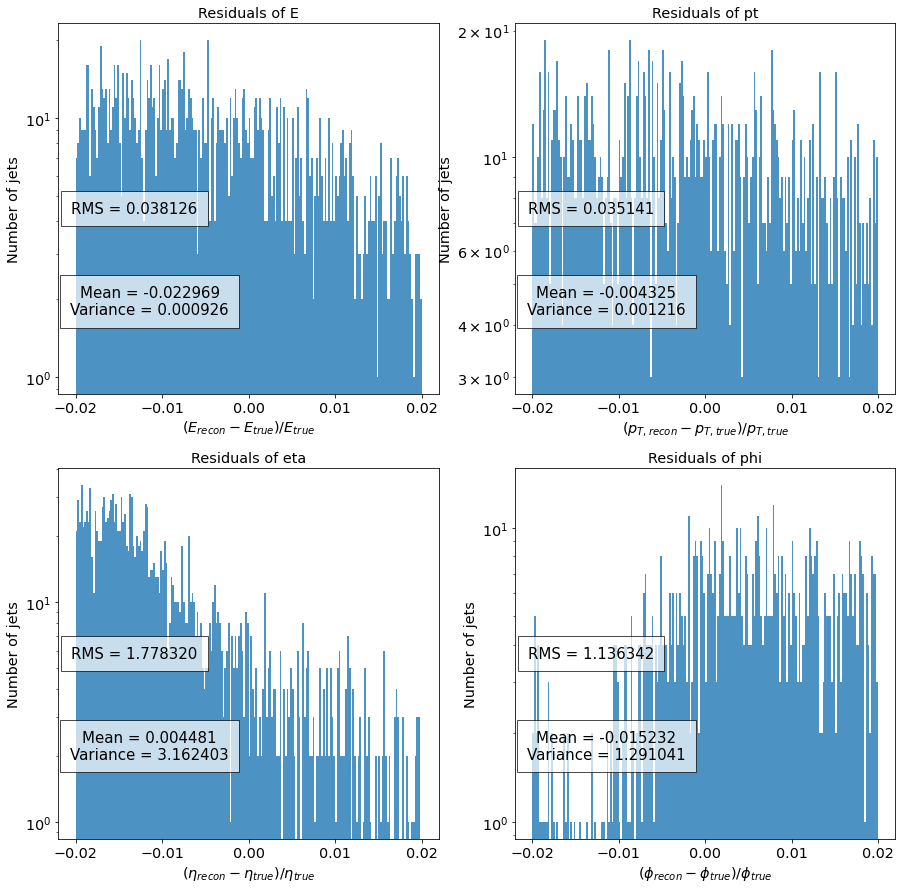

In [34]:
plot_residuals(unnormed_test_data, unnormed_test_pred, save=True)

In [26]:
def calc_mse_test(normed_test_data, pred):
    return (normed_test_data - pred).square().mean()

In [27]:
calc_mse_test(normed_test_data, pred)#Overall MSE

tensor(0.0002, grad_fn=<MeanBackward0>)

In [35]:
calc_mse_test(normed_test_data[:, 0], pred[:, 0])#MSE for E

tensor(3.2160e-05, grad_fn=<MeanBackward0>)

In [36]:
calc_mse_test(normed_test_data[:, 1], pred[:, 1])#MSE for pt

tensor(2.5924e-05, grad_fn=<MeanBackward0>)

In [37]:
calc_mse_test(normed_test_data[:, 2], pred[:, 2])#MSE for eta

tensor(0.0002, grad_fn=<MeanBackward0>)

In [38]:
calc_mse_test(normed_test_data[:, 3], pred[:, 3])#MSE for phi

tensor(0.0007, grad_fn=<MeanBackward0>)